In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients -- these are generate  by Camera Calibration.ipynb
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


def road_perspective(img, src, dst, mtx, dist):

    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # get the inverse M matrix as well
    Minv = cv2.getPerspectiveTransform(dst,src)
    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img.shape[1::-1], flags=cv2.INTER_LINEAR) # img.shape[1::-1]cause it's 3 channels now
    
    return warped, M, Minv

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if len(lines)>0:
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
## Let's try            
img = mpimg.imread('test_images/straight_lines2.jpg')            
            
lines = np.array([(195,img.shape[0],595,450),(1122,img.shape[0],685,450)],dtype=np.int)

src = np.float32([np.array([lines[0][:2]]),np.array([lines[0][2:4]]),
                  np.array([lines[1][:2]]),np.array([lines[1][2:4]])])
dst = np.float32([np.array([[325,img.shape[0]]]),np.array([[325,0]]),
                  np.array([[975,img.shape[0]]]),np.array([[975,0]])])



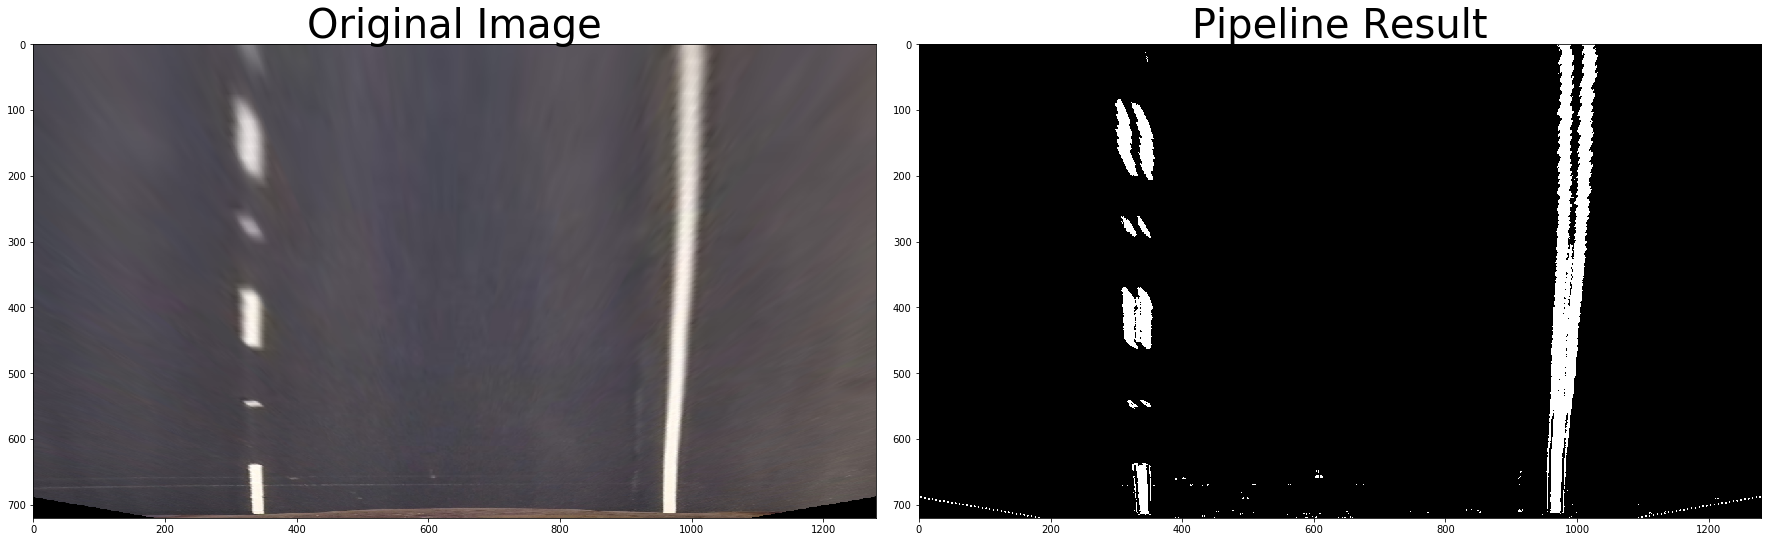

In [2]:
# Now, can I detect lines on the warped image?

def threshold_pipeline(img, s_thresh=(125, 255), sx_thresh=(15, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x -- l_channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x -- originally from l channel
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel) # original is s_channel
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    # Compute the binary output as well
    gs_binary = np.zeros_like(s_binary)
    gs_binary[ (sxbinary == 1) | (s_binary == 1) ] = 255

    return gs_binary

top_down, perspective_M, mi = road_perspective(img, src, dst, mtx, dist)
result = threshold_pipeline(top_down)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


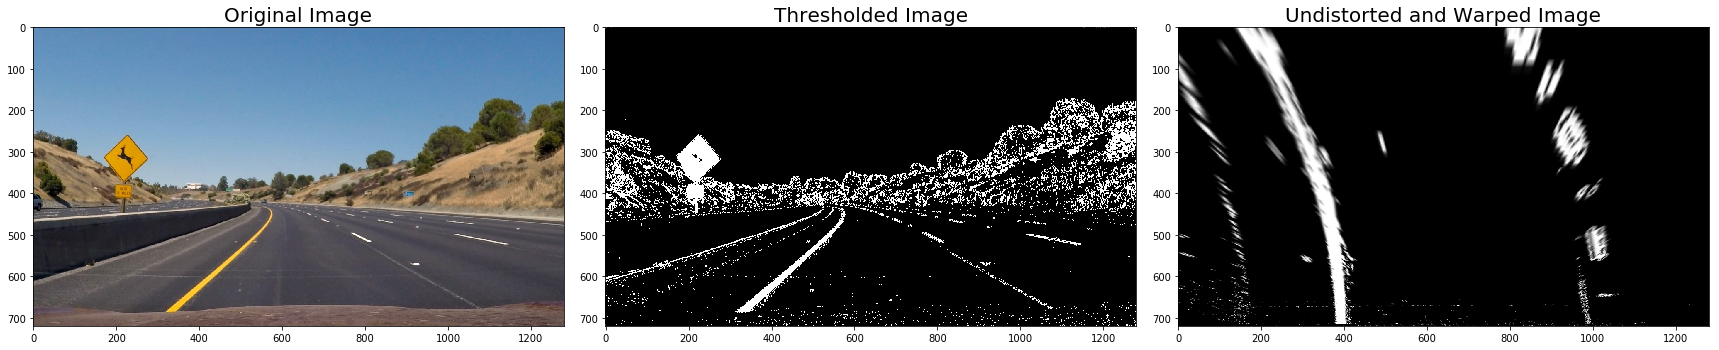

In [3]:
# Now can I do the same with a curved lines?

img = mpimg.imread('test_images/test2.jpg')

result = threshold_pipeline(img)
top_down, perspective_M, mi = road_perspective(result, src, dst, mtx, dist)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
ax3.imshow(top_down,cmap='gray')
ax3.set_title('Undistorted and Warped Image', fontsize=20)


In [ ]:
## so we need to actually mask the interesting region beforehand I think!

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(0.2*img.shape[1],0.92*img.shape[0]),
                      (img.shape[1]*0.49, 420),
                      (img.shape[1]*0.51, 420),
                      (img.shape[1]*0.95,0.92*img.shape[0])]],
            dtype=np.int32)



img = mpimg.imread('test_images/test2.jpg')

result = threshold_pipeline(img)
result_masked = region_of_interest(result,vertices)
top_down, perspective_M, mi = road_perspective(result_masked, src, dst, mtx, dist)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
ax3.imshow(result_masked,cmap='gray')
ax3.set_title('Masked Image', fontsize=20)
ax4.imshow(top_down,cmap='gray')
ax4.set_title('Undistorted and Warped Image', fontsize=20)




In [ ]:
# Test on another image 

img = mpimg.imread('test_images/test1.jpg')

result = threshold_pipeline(img)
result_masked = region_of_interest(result,vertices)
top_down, perspective_M, mi = road_perspective(result_masked, src, dst, mtx, dist)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
ax3.imshow(result_masked,cmap='gray')
ax3.set_title('Masked Image', fontsize=20)
ax4.imshow(top_down,cmap='gray')
ax4.set_title('Undistorted and Warped Image', fontsize=20)


In [ ]:
# Test on another image 

img = mpimg.imread('test_images/test5.jpg')

result = threshold_pipeline(img)
result_masked = region_of_interest(result,vertices)
top_down, perspective_M, mi = road_perspective(result_masked, src, dst, mtx, dist)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
ax3.imshow(result_masked,cmap='gray')
ax3.set_title('Masked Image', fontsize=20)
ax4.imshow(top_down,cmap='gray')
ax4.set_title('Undistorted and Warped Image', fontsize=20)

## Here we can see a potential problem, the shades cast an horizontal line which is detected. Shound't be a big problem
# since the sliding windows would still be not too far off the mark there, and the middle part simply disregarded

In [ ]:
# mpimg.imsave(arr=top_down,fname="examples/warped_example.jpg",cmap='gray')

In [ ]:
## Now let's try to detect the lines using an histograms / convolutions and then estimate a polynomial on them
def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set the width of the window
    conv_kern = np.ones(margin) # Create our window template that we will use for convolutions
    offset = margin/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-margin/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-margin/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane = []
    right_lane = []
    y = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Draw the levels on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            
        image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
        conv_signal = np.convolve(conv_kern, image_layer)

        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset

        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
           
        # Append these points to the lists
        left_lane.append(l_center)
        right_lane.append(r_center)
        y.append( ( win_y_low + win_y_high )/2. )
            
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        leftx_current = l_center
        rightx_current = r_center
    
    # end level loop
            
    return left_lane, y, right_lane, y, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    print( left_fit )

    ## Visualization ##
    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]
    # doesn't make sense for just one piont per window and moreover is not working, so ...

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

## redefine to apply undistort before thresholding
def road_perspective(img, src, dst):

    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # get the inverse M matrix as well
    Minv = cv2.getPerspectiveTransform(dst,src)
    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR) # img.shape[1::-1]cause it's 3 channels now
    
    return warped, M, Minv

img = mpimg.imread('test_images/test5.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)
result = threshold_pipeline(undist)
result_masked = region_of_interest(result,vertices)
binary_warped, perspective_M, mi = road_perspective(result_masked, src, dst)

# mpimg.imsave(arr=binary_warped,fname="examples/warped_example.jpg",cmap='gray')

out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [ ]:
## Maybe use more than one pint per window though
from random import sample

def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set the width of the window
    conv_kernel_width = margin//4
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Draw the levels on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
  
        ## If you found > minpix pixels, recenter next level ###
        if len(good_left_inds) >= minpix or len(good_right_inds) >= minpix:  # could be ==
            
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(conv_kern, image_layer)
        
            if len(good_left_inds) >= minpix:
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                
                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_left_inds) >= 2*minpix:
                    good_left_inds = good_left_inds[sample( k=2*minpix , population=range(len(good_left_inds)) )]


            if len(good_right_inds) >= minpix:
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_right_inds) >= 2*minpix:
                    good_right_inds = good_right_inds[sample( k=2*minpix , population=range(len(good_right_inds)) )]
                
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            leftx_current = l_center
            rightx_current = r_center
            
        # Append these indices to the lists
        left_lane_inds.append( good_left_inds )
        right_lane_inds.append( good_right_inds )

    
    # end level loop
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

img = mpimg.imread('test_images/test5.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)
result = threshold_pipeline(undist)
result_masked = region_of_interest(result,vertices)
binary_warped, perspective_M, mi = road_perspective(result_masked, src, dst)

# mpimg.imsave(arr=binary_warped,fname="examples/warped_example.jpg",cmap='gray')

out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [ ]:
## We also need to be able to estimate the curvature of the road from the two lines, so ...
## Modify the previous function not to plot the green boxes and to output the image with overlayed curvatures

def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set the width of the window
    conv_kernel_width = margin//4
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Compute the good pixel indexes
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
  
        ## If you found > minpix pixels, recenter next level ###
        if len(good_left_inds) >= minpix or len(good_right_inds) >= minpix:  # could be ==
            
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(conv_kern, image_layer)
        
            if len(good_left_inds) >= minpix:
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                
                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_left_inds) >= 2*minpix:
                    good_left_inds = good_left_inds[sample( k=2*minpix , population=range(len(good_left_inds)) )]


            if len(good_right_inds) >= minpix:
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_right_inds) >= 2*minpix:
                    good_right_inds = good_right_inds[sample( k=2*minpix , population=range(len(good_right_inds)) )]
                
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            leftx_current = l_center
            rightx_current = r_center
            
        # Append these indices to the lists
        left_lane_inds.append( good_left_inds )
        right_lane_inds.append( good_right_inds )

    
    # end level loop
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def measure_curvature(ploty, left_fit, right_fit , ym_per_pix , xm_per_pix ):
    '''
    Calculates the curvature of polynomial functions in meters and offset from center of the lane.
    '''  
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2) / np.abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2) / np.abs(2*right_fit[0]) ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


def fit_polynomial_curvature_offset(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_bottom = left_fit[0]*np.max(ploty)**2 + left_fit[1]*np.max(ploty) + left_fit[2]
        right_bottom = right_fit[0]*np.max(ploty)**2 + right_fit[1]*np.max(ploty) + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!') ## TODO do something better here, like reuse past values
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)
        right_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)

        
    ## Measure curvature and offset

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lcr, rcr = measure_curvature( ploty, left_fit, right_fit , ym_per_pix , xm_per_pix )
    
    offset_px = np.mean([left_bottom,right_bottom]) - binary_warped.shape[1]//2 ## this is pixels
    offset_m = offset_px * xm_per_pix
    
    ## Visualization ##
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Add (mean) curvature in the top left corner
    text = "Curvature = "+str(np.mean([lcr,rcr])) + "m"
    plt.text(10,60,s=text,weight='bold',family='sans-serif',size='x-large',color='white')
    
    # Add offset on the top left corner
    text = "The car is " + str( abs( round(offset_m,2) ) ) + "m"
    if offset_m <= 0:
        text = text + " right of center"
    else:
        text = text + " left of center"
    plt.text(10,110,s=text,weight='bold',family='sans-serif',size='x-large',color='white')

    ## return
    return out_img, lcr, rcr, offset_m, left_fitx, right_fitx, ploty


img = mpimg.imread('test_images/test5.jpg')


undist = cv2.undistort(img, mtx, dist, None, mtx)
result = threshold_pipeline(undist)
result_masked = region_of_interest(result,vertices)
binary_warped, perspective_M, mi = road_perspective(result_masked, src, dst)
out_img, lcr, rcr, offset, left_fitx, right_fitx, ploty = fit_polynomial_curvature_offset(binary_warped)

plt.imshow(out_img)
# plt.axvline(x=img.shape[1]//2)
# plt.axvline(x=offset/(3.7/700)+img.shape[1]//2,color='red')

In [ ]:
## Good! Now let's try to actually plot it all back on the original image (i.e. green mask for lane + text curvature)

## repeat to remove plotting of the curves
def fit_polynomial_curvature_offset(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_bottom = left_fit[0]*np.max(ploty)**2 + left_fit[1]*np.max(ploty) + left_fit[2]
        right_bottom = right_fit[0]*np.max(ploty)**2 + right_fit[1]*np.max(ploty) + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!') ## TODO do something better here, like reuse past values
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)
        right_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)

        
    ## Measure curvature and offset

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lcr, rcr = measure_curvature( ploty, left_fit, right_fit , ym_per_pix , xm_per_pix )
    
    offset_px = np.mean([left_bottom,right_bottom]) - binary_warped.shape[1]//2 ## this is pixels
    offset_m = offset_px * xm_per_pix
    
    ## Visualization ##
    # Add (mean) curvature in the top left corner
    text = "Curvature = "+str( int( np.mean([lcr,rcr]) ) ) + "m"  ## int because we don't want decimals here
    plt.text(10,60,s=text,weight='bold',family='sans-serif',size='x-large',color='white')
    
    # Add offset on the top left corner
    text = "The car is " + str( abs( round(offset_m,2) ) ) + "m"
    if offset_m <= 0:
        text = text + " right of center"
    else:
        text = text + " left of center"
    plt.text(10,110,s=text,weight='bold',family='sans-serif',size='x-large',color='white')

    ## return
    return out_img, lcr, rcr, offset_m, left_fitx, right_fitx, ploty



img = mpimg.imread('test_images/test5.jpg')


undist = cv2.undistort(img, mtx, dist, None, mtx)
result = threshold_pipeline(undist)
result_masked = region_of_interest(result,vertices)
binary_warped, perspective_M, Minv = road_perspective(result_masked, src, dst)
out_img, lcr, rcr, offset, left_fitx, right_fitx, ploty = fit_polynomial_curvature_offset(binary_warped)

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
undist = cv2.undistort(img, mtx, dist, None, mtx) ## undistor ( yes, again, sorry )
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

plt.imshow(result)
plt.savefig("output_images/example.jpg",dpi=300)

In [ ]:
## BUILD A COHESIVE PIPELINE TO DO ALL THIS IN ONE GO AND ONE FUNCTION NOW
# the function takes a frame/image and the camera calibration objects and does its job

### IMPORTS
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import sample

################## HELPER FUNCTION
def undistort( img, mtx, dist ):
    '''Undistort using mtx and dist'''
    return cv2.undistort(img, mtx, dist, None, mtx)
    
def top_down_perspective(img, src, dst):
    '''warp perspective to look down on the road'''
    # 1) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # 2) get the inverse M matrix as well
    Minv = cv2.getPerspectiveTransform(dst,src)
    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR) # img.shape[1::-1]cause it's 3 channels now
    
    return warped, M, Minv


def color_and_gradient_threshold(img, s_thresh=(125, 255), sx_thresh=(15, 100)):
    '''Convert the image to a thresholded version usin gradient and colors'''
    img = np.copy(img)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x -- l_channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x -- originally from l channel
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel) # original is s_channel
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    # Compute the binary output as well
    gs_binary = np.zeros_like(s_binary)
    gs_binary[ (sxbinary == 1) | (s_binary == 1) ] = 255

    return gs_binary


def region_of_interest(img, vertices):
    '''
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    '''
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def find_lane_pixels(binary_warped, nwindows=15, margin=100, minpix=50):
    '''Identify pixels that belong to lines'''

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Set the width of the convolution kernel
    conv_kernel_width = margin//4
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        ## Compute the good indexes
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
  
        ## If you found > minpix pixels, recenter next level ###
        if len(good_left_inds) >= minpix or len(good_right_inds) >= minpix:  # could be ==
            
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(conv_kern, image_layer)
        
            if len(good_left_inds) >= minpix:
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                
                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_left_inds) >= 2*minpix:
                    good_left_inds = good_left_inds[sample( k=2*minpix , population=range(len(good_left_inds)) )]


            if len(good_right_inds) >= minpix:
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_right_inds) >= 2*minpix:
                    good_right_inds = good_right_inds[sample( k=2*minpix , population=range(len(good_right_inds)) )]
                
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            leftx_current = l_center
            rightx_current = r_center
            
        # Append these indices to the lists
        left_lane_inds.append( good_left_inds )
        right_lane_inds.append( good_right_inds )

    
    # end level loop
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def measure_curvature(ploty, left_fit, right_fit , ym_per_pix , xm_per_pix ):
    '''
    Calculates the curvature of polynomial functions in meters and offset from center of the lane.
    '''  
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2) / np.abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2) / np.abs(2*right_fit[0]) ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


def fit_polynomial_curvature_offset(binary_warped, nwindows=15, margin=100, minpix=50):
    '''
    Fit a 2nd degree polynomial to the lane pixel to derived a curved approx of it
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped,nwindows,margin,minpix)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_bottom = left_fit[0]*np.max(ploty)**2 + left_fit[1]*np.max(ploty) + left_fit[2]
        right_bottom = right_fit[0]*np.max(ploty)**2 + right_fit[1]*np.max(ploty) + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!') ## TODO do something better here, like reuse past values
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)
        right_bottom = 1*np.max(ploty)**2 + 1*np.max(ploty)

    ## Measure curvature and offset
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ## TODO rescale parabula's coeffs to the correct measurement unit
    
    lcr, rcr = measure_curvature( ploty, left_fit, right_fit , ym_per_pix , xm_per_pix )
    
    offset_px = np.mean([left_bottom,right_bottom]) - binary_warped.shape[1]//2 ## this is pixels
    offset_m = offset_px * xm_per_pix

    ## return
    return lcr, rcr, offset_m, left_fitx, right_fitx, ploty, left_fit, right_fit

def draw_final(original_undist, left_fitx, right_fitx, ploty, Minv, lcr, rcr, offset):
    '''
    Draw the final image by superimposing the original with a mask made of all the info derived till now
    '''
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(original_undist[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_undist.shape[1], original_undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_undist, 1, newwarp, 0.3, 0)
    
    ## Info ##
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 3

    # Add (mean) curvature in the top left corner
    
    straight_road = 1e4 ## at this point I can consider the road straight
    
    if lcr > straight_road:
        if rcr > straight_road:
            curvature = "None"
        else:
            curvature = str( int( rcr ) ) + "m"
    else:
        if rcr > straight_road:
            curvature = str( int( lcr ) ) + "m"
        else:
            curvature = str( int( np.mean([lcr,rcr]) ) ) + "m"
        
    text = "Curvature = "+ curvature  ## int because we don't want decimals here
    
    cv2.putText(result,text, 
        (10,60), 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    # Add offset on the top left corner
    text = "The car is " + str( abs( round(offset,2) ) ) + "m"
    if offset <= 0:
        text = text + " right of center"
    else:
        text = text + " left of center"
    
    cv2.putText(result,text, 
        (10,110), 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    return result


In [ ]:
############# PIPELINE
def pipeline_first_detection(image, mtx, dist):
    '''Putting it all together in a single function'''
    vertices = np.array([[(0.2*image.shape[1],0.92*image.shape[0]),
                      (image.shape[1]*0.49, 420),
                      (image.shape[1]*0.51, 420),
                      (image.shape[1]*0.95,0.92*image.shape[0])]],
            dtype=np.int32)

    lines = np.array([(195,image.shape[0],595,450),(1122,image.shape[0],685,450)],dtype=np.int)

    src = np.float32([np.array([lines[0][:2]]),np.array([lines[0][2:4]]),
                      np.array([lines[1][:2]]),np.array([lines[1][2:4]])])
    dst = np.float32([np.array([[325,image.shape[0]]]),np.array([[325,0]]),
                      np.array([[975,image.shape[0]]]),np.array([[975,0]])])

    undist = undistort( image , mtx, dist )

    undist_thresholded = color_and_gradient_threshold(undist)

    binary_masked = region_of_interest(undist_thresholded,vertices)

    binary_warped, perspective_M, Minv = top_down_perspective( binary_masked, src, dst )

    lcr, rcr, offset, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial_curvature_offset(
        binary_warped=binary_warped,nwindows=15, margin=100, minpix=100)

    res = draw_final(undist, left_fitx, right_fitx, ploty, Minv, lcr, rcr, offset)

    return res, left_fit, right_fit

In [ ]:
# Load camera calibration parameters
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Load up an image
img = mpimg.imread('test_images/test5.jpg')
# img = mpimg.imread('test_images/straight_lines2.jpg')

## DO IT
result, lfit, rfit = pipeline_first_detection(img,mtx,dist)

plt.imshow(result)
# plt.savefig("output_images/example.jpg",dpi=300)

### THE PROBLEM LIES IN THE FACT THAT THE LINES I DEFINED FOR THE PERSPECTIVE 
# TRANS WERE ON UNDISTORTED IMAGES, SO I NEED TO START OVER

In [ ]:
## Here let's see if we can detect them again for a "subsequent frame" (from test5.jpg to test1.jpg)

def search_around_poly(binary_warped,left_fit,right_fit, margin = 100):
    # HYPERPARAMETER

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_x = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    right_lane_x = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = ((nonzerox > (left_lane_x - margin)) & (nonzerox < (left_lane_x + margin)))
    right_lane_inds = ((nonzerox > (right_lane_x - margin)) & (nonzerox < (right_lane_x + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit( lefty, leftx, 2 )
    right_fit = np.polyfit( righty, rightx, 2 )
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


vertices = np.array([[(0.2*img.shape[1],0.92*img.shape[0]),
                  (img.shape[1]*0.49, 420),
                  (img.shape[1]*0.51, 420),
                  (img.shape[1]*0.95,0.92*img.shape[0])]],
        dtype=np.int32)

lines = np.array([(195,img.shape[0],595,450),(1122,img.shape[0],685,450)],dtype=np.int)

src = np.float32([np.array([lines[0][:2]]),np.array([lines[0][2:4]]),
                  np.array([lines[1][:2]]),np.array([lines[1][2:4]])])
dst = np.float32([np.array([[325,img.shape[0]]]),np.array([[325,0]]),
                  np.array([[975,img.shape[0]]]),np.array([[975,0]])])


img = mpimg.imread('test_images/test1.jpg')

undist = undistort( img , mtx, dist )
undist_thresholded = color_and_gradient_threshold(undist)
binary_masked = region_of_interest(undist_thresholded,vertices)
binary_warped, perspective_M, Minv = top_down_perspective( binary_masked, src, dst )


result = search_around_poly(binary_warped,lfit,rfit)
plt.imshow(result)


In [ ]:
## Make it into a pipeline

def search_around_poly(binary_warped,left_fit,right_fit, margin = 100):
    '''Search but not draw around the previous fits'''
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_x = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    right_lane_x = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = ((nonzerox > (left_lane_x - margin)) & (nonzerox < (left_lane_x + margin)))
    right_lane_inds = ((nonzerox > (right_lane_x - margin)) & (nonzerox < (right_lane_x + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit( lefty, leftx, 2 )
    right_fit = np.polyfit( righty, rightx, 2 )
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_bottom = left_fit[0]*np.max(ploty)**2 + left_fit[1]*np.max(ploty) + left_fit[2]
    right_bottom = right_fit[0]*np.max(ploty)**2 + right_fit[1]*np.max(ploty) + right_fit[2]

    ## Measure curvature and offset
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lcr, rcr = measure_curvature( ploty, left_fit, right_fit , ym_per_pix , xm_per_pix )
    
    offset_px = np.mean([left_bottom,right_bottom]) - binary_warped.shape[1]//2 ## this is pixels
    offset_m = offset_px * xm_per_pix

    ## return
    return lcr, rcr, offset_m, left_fitx, right_fitx, ploty, left_fit, right_fit


def pipeline_onwards(image, mtx, dist,left_fit,right_fit):
    undist = undistort( image , mtx, dist )
    undist_thresholded = color_and_gradient_threshold(undist)
    binary_masked = region_of_interest(undist_thresholded,vertices)
    binary_warped, perspective_M, Minv = top_down_perspective( binary_masked, src, dst )
    
    lcr, rcr, offset, left_fitx, right_fitx, ploty, left_fit, right_fit = \
        search_around_poly(binary_warped,left_fit,right_fit)

    result = draw_final(undist, left_fitx, right_fitx, ploty, Minv, lcr, rcr, offset)

    return result, left_fit, right_fit

In [ ]:
# Load camera calibration parameters
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Load up an image
img1 = mpimg.imread('test_images/test6.jpg')
## Do first detection
result1, lfit1, rfit1 = pipeline_first_detection(img1,mtx,dist)

# load up second image
img2 = mpimg.imread('test_images/test4.jpg')
## Do second detection
result2, lfit2, rfit2 = pipeline_onwards(img2,mtx,dist,lfit1,rfit1)

# load up third image
img3 = mpimg.imread('test_images/test1.jpg')
## Do second detection
result3, lfit3, rfit3 = pipeline_onwards(img3,mtx,dist,lfit2,rfit2)

# load up fourth image
img4 = mpimg.imread('test_images/test5.jpg')
## Do second detection
result4, lfit4, rfit4 = pipeline_onwards(img4,mtx,dist,lfit3,rfit3)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result1)
ax1.set_title('First Image', fontsize=20)
ax2.imshow(result2)
ax2.set_title('Second Image', fontsize=20)
ax3.imshow(result3)
ax3.set_title('Third Image', fontsize=20)
ax4.imshow(result4)
ax4.set_title('Fourth Image', fontsize=20)

In [ ]:
## Now need to build the Line object and see if we can build a pipeline that takes it and updates it

In [ ]:
# Continued in objPipeline.ipynb